### **0. Notebook Overview and Learning Goals**

In this final notebook of **Project 11**, we bring together everything we’ve learned so far about **transfer learning** — from understanding pretrained representations to training custom classifier heads and fine-tuning deeper layers.

**🧩 Recap of the Journey So Far**

- In **NB01**, we explored how pretrained CNNs such as ResNet-18 learn rich hierarchical features (edges → shapes → objects).  
  We froze all weights and attached a new **classifier head** for our Caltech-101 subset.

- In **NB02**, we trained only the **new head** while keeping the backbone frozen — a process called **feature extraction**.  
  This approach was efficient and effective, reusing ImageNet-learned representations without altering them.

- In **NB03**, we took a step further and **unfroze deeper layers** (specifically `layer4`) to perform **fine-tuning**.  
  This allowed the model to slightly adjust its learned filters to better fit our dataset’s textures and patterns.

**🎯 What We Aim to Learn Here**

In this notebook, we will explore how well our **fine-tuned model** generalizes beyond the data it has seen.  
We’ll compare three models — pretrained, feature-extracted, and fine-tuned — both **quantitatively** and **visually**.

By the end, we’ll be able to:

- 🔹 Perform inference using the fine-tuned model on **test images** and some **unseen categories**.  
- 🔹 Compare model predictions, confidence, and class-level performance.  
- 🔹 Reflect on **generalization, efficiency, and ethical implications** of transfer learning and model reuse.


> **Key Question:**  
> Does fine-tuning truly make the model more *intelligent*, or just more *specialized*?  
> By the end of this notebook, we’ll have both empirical and conceptual insights into this trade-off.

---

### **1. Revisiting Our Models**

Before we dive into evaluation and comparison, let’s recall the **three models** we’ve worked with throughout this project.  
Each represents a distinct stage of the **transfer learning pipeline**, illustrating how pretraining knowledge can be reused, extended, or refined.

**🧠 The Three Stages of Transfer Learning**

1. **Pretrained Model (Baseline)**
   - ResNet-18 trained on **ImageNet (1,000 classes)**.
   - We use it *as is*, without any retraining.
   - Serves as our **reference point** for “generic visual intelligence”.

2. **Feature-Extracted Model (NB02)**
   - Backbone (all convolutional layers) **frozen**.
   - Only the **new classifier head** trained on the **Caltech-101 subset (10 classes)**.
   - Fast and efficient — reuses existing features, suitable when data is limited.

3. **Fine-Tuned Model (NB03)**
   - Backbone **partially unfrozen** (only `layer4` and classifier head).
   - Both layers trained jointly with a **small learning rate**.
   - Allows subtle adaptation of deep features to match Caltech’s domain.

**⚙️ What We’ll Do Here**

We will:
- Reload all three checkpoints.
- Inspect which parameters are frozen or trainable.
- Compare their design philosophy in a simple summary table.

This sets the foundation for analyzing **how these models differ in what they “see” and “understand.”**


**Reload Models and Inspect Parameters**

In [2]:
import torch
import torch.nn as nn
from torchvision import models

# === Utility Function to Count Parameters ===
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# === Load base ResNet and get feature size ===
base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = base_model.fc.in_features

# --- 1) Pretrained baseline: "pure reuse" (we don't train it in our project) ---
model_pretrained = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Keep original 1000-class head or (if we prefer) swap to 10-class; either way:
for p in model_pretrained.parameters():
    p.requires_grad = False    # conceptually: 0 trainable params in our project

# --- 2) Feature-extracted model (NB02): backbone frozen, head trainable ---
model_feature = models.resnet18(weights=None)
model_feature.fc = nn.Linear(num_features, 10)
model_feature.load_state_dict(
    torch.load("./checkpoints/resnet18_feature_extraction.pth", weights_only=False, map_location="cpu")
)

# Freeze everything first
for p in model_feature.parameters():
    p.requires_grad = False
# Unfreeze only classifier head (this is what we *trained* in NB02)
for p in model_feature.fc.parameters():
    p.requires_grad = True

# --- 3) Fine-tuned model (NB03): layer4 + head trainable ---
model_finetuned = models.resnet18(weights=None)
model_finetuned.fc = nn.Linear(num_features, 10)
model_finetuned.load_state_dict(
    torch.load("./checkpoints/resnet18_finetuned.pth", weights_only=False, map_location="cpu")
)

# Freeze all layers first
for p in model_finetuned.parameters():
    p.requires_grad = False
# Unfreeze only layer4 and head (this is what we *trained* in NB03)
for p in model_finetuned.layer4.parameters():
    p.requires_grad = True
for p in model_finetuned.fc.parameters():
    p.requires_grad = True

# === Inspect which parameters are trainable ===
def print_trainable_layers(model, name):
    trainable_layers = [n for n, p in model.named_parameters() if p.requires_grad]
    print(f"\nModel: {name}")
    print(f"Trainable layers: {len(trainable_layers)} out of {len(list(model.parameters()))}")
    print("Example trainable params:",
          trainable_layers[-5:] if trainable_layers else "None")

print_trainable_layers(model_pretrained, "Pretrained (ImageNet)")
print_trainable_layers(model_feature, "Feature-Extracted (NB02)")
print_trainable_layers(model_finetuned, "Fine-Tuned (NB03)")

# === Count parameters ===
for name, mdl in zip(
    ["Pretrained", "Feature-Extracted", "Fine-Tuned"],
    [model_pretrained, model_feature, model_finetuned]
):
    total, trainable = count_params(mdl)
    print(f"{name:18s} | Total: {total/1e6:.2f}M | "
          f"Trainable: {trainable/1e6:.4f}M | "
          f"Frozen: {(total-trainable)/1e6:.4f}M")



Model: Pretrained (ImageNet)
Trainable layers: 0 out of 62
Example trainable params: None

Model: Feature-Extracted (NB02)
Trainable layers: 2 out of 62
Example trainable params: ['fc.weight', 'fc.bias']

Model: Fine-Tuned (NB03)
Trainable layers: 17 out of 62
Example trainable params: ['layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'fc.weight', 'fc.bias']
Pretrained         | Total: 11.69M | Trainable: 0.0000M | Frozen: 11.6895M
Feature-Extracted  | Total: 11.18M | Trainable: 0.0051M | Frozen: 11.1765M
Fine-Tuned         | Total: 11.18M | Trainable: 8.3989M | Frozen: 2.7828M


**🔍 Interpretation of Results**

The parameter summaries reveal how differently each model adapts during training. The pretrained baseline remains fully frozen, the feature-extraction model updates only its classifier head, and the fine-tuned model updates the entire final residual block along with the head. This progression shows how we move from pure reuse → lightweight adaptation → deeper specialization.

| Model | Layers Trained        | Total Params | Trainable Params | Strategy           | Typical Learning Rate |
|:------|:----------------------|:-------------|:-----------------|:-------------------|:----------------------|
| **Pretrained (Baseline)**        | None (all frozen)      | 11.69M       | **0.0M**         | Pure reuse           | N/A                  |
| **Feature Extraction (NB02)**    | Classifier head only   | 11.18M       | **~0.005M**      | Efficient reuse      | 1e-3                 |
| **Fine-Tuned (NB03)**            | Layer4 + Head          | 11.18M       | **~8.40M**       | Targeted adaptation  | 1e-4 → 1e-3          |

We observe a clear trade-off:

- **Smaller trainable sets → faster, more stable training**, but limited specialization.  
- **Larger trainable sets → higher flexibility**, but increased overfitting risk and compute cost.

| Strategy                | Trainable Capacity   | Adaptation Strength | Overfitting Risk | Suitable When…                                                      |
|-------------------------|-----------------------|----------------------|-------------------|-----------------------------------------------------------------------|
| **Pretrained (Frozen)** | None                  | None                 | None              | We need a baseline or extremely fast inference; zero training.        |
| **Feature Extraction**  | Very small (~0.005M)  | Limited              | Very low          | Small datasets; moderate similarity to ImageNet.                      |
| **Fine-Tuning**         | Large (~8.4M)         | Strong               | Moderate–High     | Dataset has domain differences; enough samples to support learning.   |


> 💡 **Key Takeaway:**  
> Transfer learning is a spectrum—from frozen reuse to deep adaptation. Choosing the right point depends on dataset size, domain similarity, and available compute.


---

**✅ Code Task 11.4.1.1 – Reload Fine-Tuned CT Model & Inspect Parameters**

**Instruction**: Reload the fine-tuned ResNet18 model we saved in NB03 (with layer3 and layer4 unfrozen).
We will recreate the same ResNet18 architecture and final classifier layer, load the saved weights from `resnet18_finetuned_CT_NB03.pth`, store the model in `CT_model_finetuned_CT_NB03`, unfreeze layer3/layer4/head and at last compute and print `CT_total_params`, `CT_trainable_params`, `CT_frozen_params`.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# CT_Task 1 – Reload fine-tuned CT model and inspect parameters

# 1. Recreate ResNet18 backbone (same as in NB03)
CT_model_finetuned_CT_NB03 = models.resnet18(weights=None)  # architecture only

# 2. Replace final fully-connected layer to match Caltech-101 classes
CT_num_classes = ...
CT_model_finetuned_CT_NB03.fc = nn.Linear(
..., CT_num_classes
)

# 3. Load saved weights from NB03
CT_checkpoint_path = "resnet18_layer34_ct_finetuned_NB03.pth"
CT_state_dict = torch.load(..., weights_only=False, map_location="cpu")
CT_model_finetuned_CT_NB03.load_state_dict(...)

# 4. Reapply fine-tuning pattern: freeze all, unfreeze layer3+layer4+fc
for p in CT_model_finetuned_CT_NB03.parameters():
    p.requires_grad = False

for p in CT_model_finetuned_CT_NB03.layer3.parameters():
    p.requires_grad = True

for p in CT_model_finetuned_CT_NB03.layer4.parameters():
    p.requires_grad = ...

for p in CT_model_finetuned_CT_NB03.fc.parameters():
    p.requires_grad = ...

# 5. Compute parameter counts
CT_total_params = ...
CT_trainable_params = ...
CT_frozen_params = ...

print(f"Total parameters:    {CT_total_params}")
print(f"Trainable parameters:{CT_trainable_params}")
print(f"Frozen parameters:   {CT_frozen_params}")


**Instructor Solution**

In [12]:
import torch
import torch.nn as nn
from torchvision import models

# CT_Task 1 – Reload fine-tuned CT model and inspect parameters

# 1. Recreate ResNet18 backbone (same as in NB03)
CT_model_finetuned_CT_NB03 = models.resnet18(weights=None)  # architecture only

# 2. Replace final fully-connected layer to match Caltech-101 classes
CT_num_classes = 10
CT_model_finetuned_CT_NB03.fc = nn.Linear(
    CT_model_finetuned_CT_NB03.fc.in_features,
    CT_num_classes
)

# 3. Load saved weights from NB03
CT_checkpoint_path = "resnet18_layer34_ct_finetuned_NB03.pth"
CT_state_dict = torch.load(CT_checkpoint_path, weights_only=False, map_location="cpu")
CT_model_finetuned_CT_NB03.load_state_dict(CT_state_dict)

# 4. Reapply fine-tuning pattern: freeze all, unfreeze layer3+layer4+fc
for p in CT_model_finetuned_CT_NB03.parameters():
    p.requires_grad = False

for p in CT_model_finetuned_CT_NB03.layer3.parameters():
    p.requires_grad = True

for p in CT_model_finetuned_CT_NB03.layer4.parameters():
    p.requires_grad = True

for p in CT_model_finetuned_CT_NB03.fc.parameters():
    p.requires_grad = True

# 5. Compute parameter counts
CT_total_params = sum(p.numel() for p in CT_model_finetuned_CT_NB03.parameters())
CT_trainable_params = sum(p.numel() for p in CT_model_finetuned_CT_NB03.parameters() if p.requires_grad)
CT_frozen_params = CT_total_params - CT_trainable_params

print(f"Total parameters:    {CT_total_params}")
print(f"Trainable parameters:{CT_trainable_params}")
print(f"Frozen parameters:   {CT_frozen_params}")


Total parameters:    11181642
Trainable parameters:10498570
Frozen parameters:   683072


In [ ]:
import torch.nn as nn
import os

assert 'CT_model_finetuned_CT_NB03' in globals(), "❌ Define CT_model_finetuned_CT_NB03."
assert isinstance(CT_model_finetuned_CT_NB03, nn.Module), "❌ CT_model_finetuned_CT_NB03 must be an nn.Module."

assert 'CT_total_params' in globals(), "❌ Define CT_total_params."
assert 'CT_trainable_params' in globals(), "❌ Define CT_trainable_params."
assert 'CT_frozen_params' in globals(), "❌ Define CT_frozen_params."

assert isinstance(CT_total_params, int) and CT_total_params > 0, "❌ CT_total_params must be a positive int."
assert isinstance(CT_trainable_params, int) and CT_trainable_params > 0, "❌ CT_trainable_params must be a positive int."
assert isinstance(CT_frozen_params, int) and CT_frozen_params >= 0, "❌ CT_frozen_params must be a non-negative int."
assert CT_total_params == CT_trainable_params + CT_frozen_params, "❌ total != trainable + frozen."

assert os.path.exists("resnet18_finetuned_CT_NB03.pth"), "❌ Saved checkpoint file not found."

print("✅ CT_Task 1 passed!")

---

### **2. Preparing the Evaluation Dataset**

To compare our three models fairly, we will evaluate them on the **held-out test split** from our Caltech-101 teaching subset.  
Optionally, we will also include a tiny **“new category” mini-set** (2–3 classes **unseen during training**) to simulate **zero-shot inference**. This lets us observe how well representations **generalize beyond trained labels**:

- If the **pretrained** model shows reasonable confidence on unseen categories, that reflects broad, generic features from ImageNet.  
- If the **feature-extracted** or **fine-tuned** models become too specialized, they may misclassify unseen categories more confidently (over-specialization).  
- This comparison helps us reason about the **specialization ↔ generalization** trade-off.

We will:
- Load the **test split** using the same preprocessing (ImageNet mean/std).  
- Verify that the **class index order** matches our saved `class_to_idx` mapping.  
- Optionally load a **new-category mini-set** (if present on disk) and build a separate loader for qualitative zero-shot inspection.


**Load test split with the saved mapping (consistency check)**

In [3]:
import torch
from torchvision import datasets, transforms
from pathlib import Path

# Paths (must match earlier notebooks)
DATA_ROOT = Path("./data/caltech101_10")
MAP_PATH  = Path("./checkpoints/class_to_idx.pth")

assert DATA_ROOT.exists(), f"Dataset not found at {DATA_ROOT}"
assert (DATA_ROOT / "test").exists(), f"Test split missing at {DATA_ROOT/'test'}"
assert MAP_PATH.exists(), f"class_to_idx mapping not found at {MAP_PATH}"

# Load saved mapping from NB01
class_to_idx_saved = torch.load(MAP_PATH, weights_only=False)
idx_to_class_saved = {v: k for k, v in class_to_idx_saved.items()}
class_names = [idx_to_class_saved[i] for i in range(len(idx_to_class_saved))]
num_classes = len(class_names)
print(f"[info] Saved classes ({num_classes}): {class_names}")

# Preprocessing (must match training notebooks)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
eval_tfms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Build test dataset/loader
test_ds = datasets.ImageFolder(DATA_ROOT / "test", transform=eval_tfms)
from torch.utils.data import DataLoader
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

print(f"[info] Test set size: {len(test_ds)} images")
print(f"[info] Test class_to_idx (from disk): {test_ds.class_to_idx}")

# Verify mapping consistency (order and names)
assert set(test_ds.class_to_idx.keys()) == set(class_to_idx_saved.keys()), \
    "Mismatch between saved classes and test folder classes."

# Build ordered list according to saved mapping (0..K-1)
ordered_from_saved = [name for name, _ in sorted(class_to_idx_saved.items(), key=lambda kv: kv[1])]
ordered_from_disk  = [name for name, _ in sorted(test_ds.class_to_idx.items(), key=lambda kv: kv[1])]
print(f"[check] Order (saved): {ordered_from_saved}")
print(f"[check] Order (disk) : {ordered_from_disk}")

assert ordered_from_saved == ordered_from_disk, \
    "Index order differs between saved mapping and current dataset. Please align folder names or mapping."

print("[ok] Class index order is consistent with saved mapping.")


[info] Saved classes (10): ['Faces', 'Motorbikes', 'airplanes', 'butterfly', 'camera', 'chair', 'laptop', 'lotus', 'panda', 'watch']
[info] Test set size: 204 images
[info] Test class_to_idx (from disk): {'Faces': 0, 'Motorbikes': 1, 'airplanes': 2, 'butterfly': 3, 'camera': 4, 'chair': 5, 'laptop': 6, 'lotus': 7, 'panda': 8, 'watch': 9}
[check] Order (saved): ['Faces', 'Motorbikes', 'airplanes', 'butterfly', 'camera', 'chair', 'laptop', 'lotus', 'panda', 'watch']
[check] Order (disk) : ['Faces', 'Motorbikes', 'airplanes', 'butterfly', 'camera', 'chair', 'laptop', 'lotus', 'panda', 'watch']
[ok] Class index order is consistent with saved mapping.


**Quick sanity peek at a few test samples (optional visual check)**

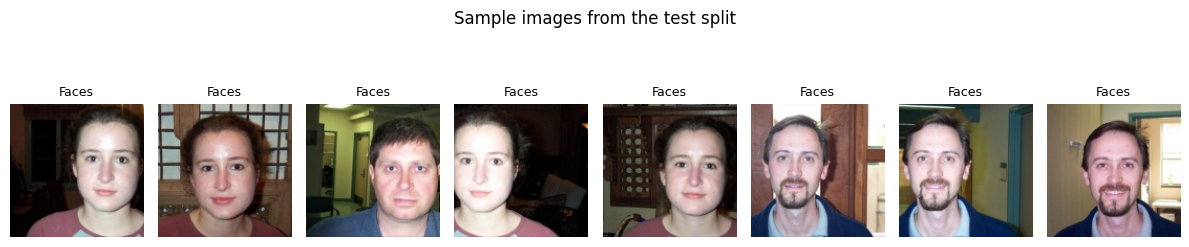

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize helper for display
def unnormalize(img, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img = img.clone()
    for c, (m, s) in enumerate(zip(mean, std)):
        img[c] = img[c] * s + m
    return img.clamp(0, 1)

xb, yb = next(iter(test_loader))
k = min(8, xb.size(0))

plt.figure(figsize=(12, 3))
for i in range(k):
    img_disp = unnormalize(xb[i]).permute(1, 2, 0).numpy()
    plt.subplot(1, k, i + 1)
    plt.imshow(img_disp)
    plt.title(class_names[yb[i].item()], fontsize=9)
    plt.axis("off")
plt.suptitle("Sample images from the test split", fontsize=12)
plt.tight_layout()
plt.show()


By verifying the **class index order** against our saved mapping and keeping **preprocessing identical** to training, we ensure a fair comparison across models.  

If we also include a **zero-shot mini-set**, we can observe how each model behaves on **unseen categories**, which is crucial for discussing **generalization** vs **specialization** in transfer learning.


---

**✅ Code Task 11.4.2.1 – Visualize Sample “Airplanes” Images**

**Instruction**: We previously visualized a few sample images from the Caltech-101 subset.
Now we will find image indices in test_dataset that belong to the "airplanes" class, then will select 4 of them, plot the corresponding images in a single row.

Use CT-prefixed variables: `CT_airplane_indices` and `CT_airplane_fig`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CT_Task 2 – Show 4 sample "airplanes" images from the test set

class_names = test_ds....
CT_airplane_class_name = "airplanes"
CT_airplane_class_idx = class_names.index(...)

CT_airplane_indices = [i for i, (_, label) in enumerate(...) if label == CT_airplane_class_idx]
CT_airplane_indices = ...[:4]

CT_airplane_fig, CT_airplane_axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, idx in zip(CT_airplane_axes, CT_airplane_indices):
    img, label = test_ds[idx]
    img_np = img.numpy().transpose(1, 2, 0)

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np)
    ax.set_title(...[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

**Instructor Solution**

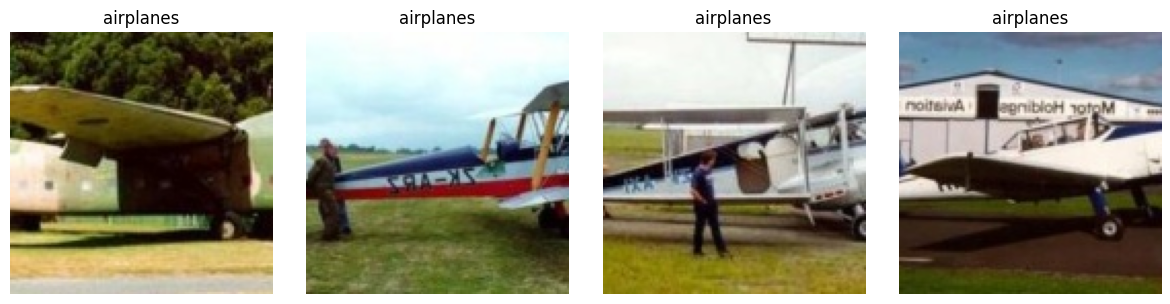

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# CT_Task 2 – Show 4 sample "airplanes" images from the test set

class_names = test_ds.classes
CT_airplane_class_name = "airplanes"
CT_airplane_class_idx = class_names.index(CT_airplane_class_name)

CT_airplane_indices = [i for i, (_, label) in enumerate(test_ds) if label == CT_airplane_class_idx]
CT_airplane_indices = CT_airplane_indices[:4]

CT_airplane_fig, CT_airplane_axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, idx in zip(CT_airplane_axes, CT_airplane_indices):
    img, label = test_ds[idx]
    img_np = img.numpy().transpose(1, 2, 0)

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np)
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.figure as mfig

assert 'CT_airplane_indices' in globals(), "❌ Define CT_airplane_indices."
assert isinstance(CT_airplane_indices, list), "❌ CT_airplane_indices must be a list."
assert len(CT_airplane_indices) == 4, "❌ CT_airplane_indices should contain exactly 4 indices."

assert 'CT_airplane_fig' in globals(), "❌ Define CT_airplane_fig."
assert isinstance(CT_airplane_fig, mfig.Figure), "❌ CT_airplane_fig must be a matplotlib Figure."

print("✅ CT_Task 2 passed!")

---

### **3. Comparing Predictions Across Models**

We will now run **side-by-side inference** on a small batch of test images using our three models:

- **Pretrained baseline** (ImageNet backbone + 10-class head, untrained)  
- **Feature-extracted** (NB02: frozen backbone, trained head)  
- **Fine-tuned** (NB03: `layer4` + head trained with small LR)

For each image we will display:
- the **true label**,  
- the **predicted label from each model**, and  
- the **confidence** (highest softmax probability).

This qualitative view helps us see which model **generalizes** better and which one **confuses** classes.  
Typically, the **fine-tuned** model is more confident on harder examples, while the **feature-extracted** model remains a very strong baseline.  
The **pretrained baseline** (with an untrained head) often produces near-random predictions and serves only as a reference point.


**Load the three models robustly (with fallbacks)**

In [17]:
import torch
import torch.nn as nn
from torchvision import models
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
CKPT = Path("./checkpoints")
CKPT_FE = CKPT / "resnet18_feature_extraction.pth"
CKPT_FT = CKPT / "resnet18_finetuned.pth"
CKPT_PRE = CKPT / "resnet18_pretrained.pth"          # optional (if you created this)
CKPT_INIT = CKPT / "resnet18_frozen_init.pth"        # saved in NB01

num_classes = len(class_names)

def make_resnet18(num_classes: int, weights="IMAGENET1K_V1"):
    m = models.resnet18(weights=getattr(models.ResNet18_Weights, weights) if isinstance(weights, str) else weights)
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, num_classes)
    return m

# --- Pretrained baseline: prefer user-saved ckpt; else NB01 init; else random head on ImageNet backbone
if CKPT_PRE.exists():
    model_pretrained = make_resnet18(num_classes, "IMAGENET1K_V1")
    model_pretrained.load_state_dict(torch.load(CKPT_PRE, weights_only=False, map_location="cpu"), strict=True)
    baseline_name = "pretrained.pth"
elif CKPT_INIT.exists():
    model_pretrained = make_resnet18(num_classes, "IMAGENET1K_V1")
    model_pretrained.load_state_dict(torch.load(CKPT_INIT, weights_only=False, map_location="cpu"), strict=True)
    baseline_name = "frozen_init.pth"
else:
    model_pretrained = make_resnet18(num_classes, "IMAGENET1K_V1")  # random 10-class head
    baseline_name = "ImageNet backbone + random 10-cls head"

model_pretrained = model_pretrained.to(device).eval()

# --- Feature extraction model (NB02)
assert CKPT_FE.exists(), f"Missing NB02 checkpoint: {CKPT_FE}"
model_feature = make_resnet18(num_classes, "IMAGENET1K_V1")
model_feature.load_state_dict(torch.load(CKPT_FE, weights_only=False, map_location="cpu"), strict=True)
# emulate FE inference setup (freezing not required for eval, but explicit)
for p in model_feature.parameters(): p.requires_grad = False
model_feature = model_feature.to(device).eval()

# --- Fine-tuned model (NB03)
assert CKPT_FT.exists(), f"Missing NB03 checkpoint: {CKPT_FT}"
model_finetuned = make_resnet18(num_classes, "IMAGENET1K_V1")
model_finetuned.load_state_dict(torch.load(CKPT_FT, weights_only=False, map_location="cpu"), strict=True)
model_finetuned = model_finetuned.to(device).eval()

print("[ok] Loaded models:")
print(f"  - Baseline: {baseline_name}")
print(f"  - Feature-extracted: {CKPT_FE.name}")
print(f"  - Fine-tuned:        {CKPT_FT.name}")


[ok] Loaded models:
  - Baseline: frozen_init.pth
  - Feature-extracted: resnet18_feature_extraction.pth
  - Fine-tuned:        resnet18_finetuned.pth


**Inference helpers and batch predictions**

In [18]:
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def predict_batch(model, xb):
    logits = model(xb.to(device))
    probs = F.softmax(logits, dim=1).cpu().numpy()
    pred_idx = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    return pred_idx, conf

# get one batch
xb, yb = next(iter(test_loader))
xb_dev = xb.to(device)

pred_pre, conf_pre = predict_batch(model_pretrained, xb)
pred_fe,  conf_fe  = predict_batch(model_feature,   xb)
pred_ft,  conf_ft  = predict_batch(model_finetuned, xb)

y_true = yb.numpy()

**Side-by-side visualization grid**

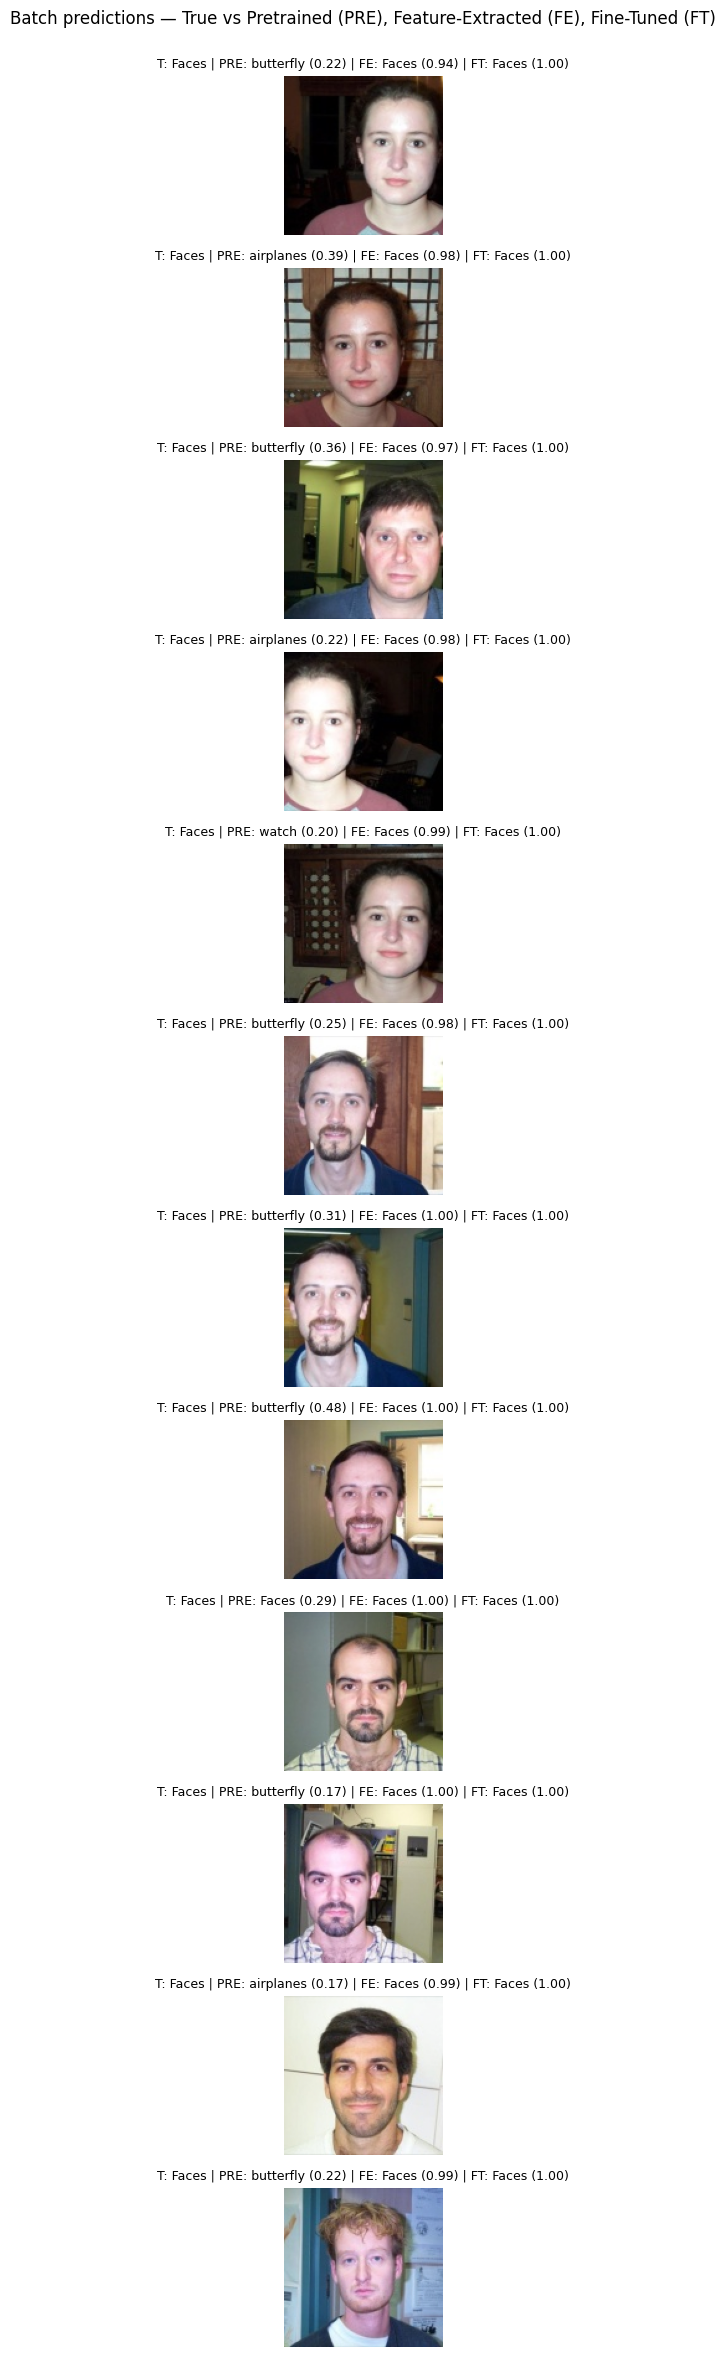

In [19]:
import matplotlib.pyplot as plt

def unnormalize(img_tensor, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    t = img_tensor.clone()
    for c,(m,s) in enumerate(zip(mean,std)):
        t[c] = t[c]*s + m
    return t.clamp(0,1)

k = min(12, xb.size(0))
cols = 3  # show 3 columns per row (we'll stack rows)
rows = k

plt.figure(figsize=(10, rows * 2.0))
for i in range(k):
    img = unnormalize(xb[i]).permute(1,2,0).numpy()
    t_lbl  = class_names[y_true[i]]
    p_pre  = class_names[pred_pre[i]]
    p_fe   = class_names[pred_fe[i]]
    p_ft   = class_names[pred_ft[i]]

    # one row per image with 1 big panel
    ax = plt.subplot(rows, 1, i+1)
    ax.imshow(img)
    title = (
        f"T: {t_lbl} | "
        f"PRE: {p_pre} ({conf_pre[i]:.2f}) | "
        f"FE: {p_fe} ({conf_fe[i]:.2f}) | "
        f"FT: {p_ft} ({conf_ft[i]:.2f})"
    )
    ax.set_title(title, fontsize=9)
    ax.axis("off")

plt.suptitle("Batch predictions — True vs Pretrained (PRE), Feature-Extracted (FE), Fine-Tuned (FT)", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()


**Compact tabular comparison for the same batch**

In [20]:
import pandas as pd

rows = []
for i in range(k):
    rows.append({
        "true": class_names[y_true[i]],
        "PRE_pred": class_names[pred_pre[i]],
        "PRE_conf": f"{conf_pre[i]:.2f}",
        "FE_pred":  class_names[pred_fe[i]],
        "FE_conf":  f"{conf_fe[i]:.2f}",
        "FT_pred":  class_names[pred_ft[i]],
        "FT_conf":  f"{conf_ft[i]:.2f}",
    })

pd.DataFrame(rows)


,true,PRE_pred,PRE_conf,FE_pred,FE_conf,FT_pred,FT_conf
0,Faces,butterfly,0.22,Faces,0.94,Faces,1.00
1,Faces,airplanes,0.39,Faces,0.98,Faces,1.00
2,Faces,butterfly,0.36,Faces,0.97,Faces,1.00
3,Faces,airplanes,0.22,Faces,0.98,Faces,1.00
4,Faces,watch,0.20,Faces,0.99,Faces,1.00
5,Faces,butterfly,0.25,Faces,0.98,Faces,1.00
6,Faces,butterfly,0.31,Faces,1.00,Faces,1.00
7,Faces,butterfly,0.48,Faces,1.00,Faces,1.00
8,Faces,Faces,0.29,Faces,1.00,Faces,1.00
9,Faces,butterfly,0.17,Faces,1.00,Faces,1.00


**What do we observe?**

 - The **pretrained baseline** (untrained 10-class head) often behaves **near-randomly** and may assign **confident but incorrect** labels — this is expected since its head is not trained.  
 - The **feature-extracted** model is usually **strong and stable**, leveraging robust pretrained features with a task-specific head.  
 - The **fine-tuned** model often shows **higher confidence** and **fewer confusions** on challenging images, especially where Caltech textures or shapes diverge from ImageNet’s.

When the fine-tuned model still makes errors, examine whether the images involve **viewpoint changes**, **occlusions**, or **background clutter**.  

Such cases motivate either **data augmentation** or **careful fine-tuning** (e.g., smaller LR, fewer layers unfrozen).


---

### **4. Quantitative Evaluation**

So far, we’ve visually compared how the **Pretrained**, **Feature-Extracted**, and **Fine-Tuned** models behave on sample images.  
We now move to a **systematic quantitative evaluation** using the test split prepared earlier.

For each model, we will compute:
- **Accuracy** – overall correctness of predictions.
- **Precision**, **Recall**, and **F1-score** (both *macro* and *weighted* averages).
- **Confusion matrix**, to visualize class-specific strengths and weaknesses.

This allows us to measure:
- Whether fine-tuning truly improves generalization.
- Whether any model has **overfit** to certain classes.
- How domain shift affects class-level performance.

We’ll also visualize confusion matrices **side by side** to identify pattern differences.


**Compute metrics for all three models**

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

def evaluate_model(model, loader, name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)
    return {
        "name": name,
        "acc": acc,
        "prec_macro": prec_macro,
        "rec_macro": rec_macro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weight,
        "cm": cm
    }

results = []
for name, model in [
    ("Pretrained", model_pretrained),
    ("Feature-Extracted", model_feature),
    ("Fine-Tuned", model_finetuned)
]:
    print(f"Evaluating {name}...")
    res = evaluate_model(model, test_loader, name)
    results.append(res)
    print(f"{name} done.")


Evaluating Pretrained...
Pretrained done.
Evaluating Feature-Extracted...
Feature-Extracted done.
Evaluating Fine-Tuned...
Fine-Tuned done.


**Display comparative metrics table**

In [22]:
import pandas as pd

df_metrics = pd.DataFrame([{
    "Model": r["name"],
    "Accuracy": f"{r['acc']*100:.2f}%",
    "F1 (Macro)": f"{r['f1_macro']*100:.2f}%",
    "F1 (Weighted)": f"{r['f1_weighted']*100:.2f}%"
} for r in results])

display(df_metrics)

,Model,Accuracy,F1 (Macro),F1 (Weighted)
0,Pretrained,4.90%,4.30%,4.54%
1,Feature-Extracted,97.55%,96.23%,97.55%
2,Fine-Tuned,99.51%,99.12%,99.51%


**Visualize confusion matrices side-by-side**

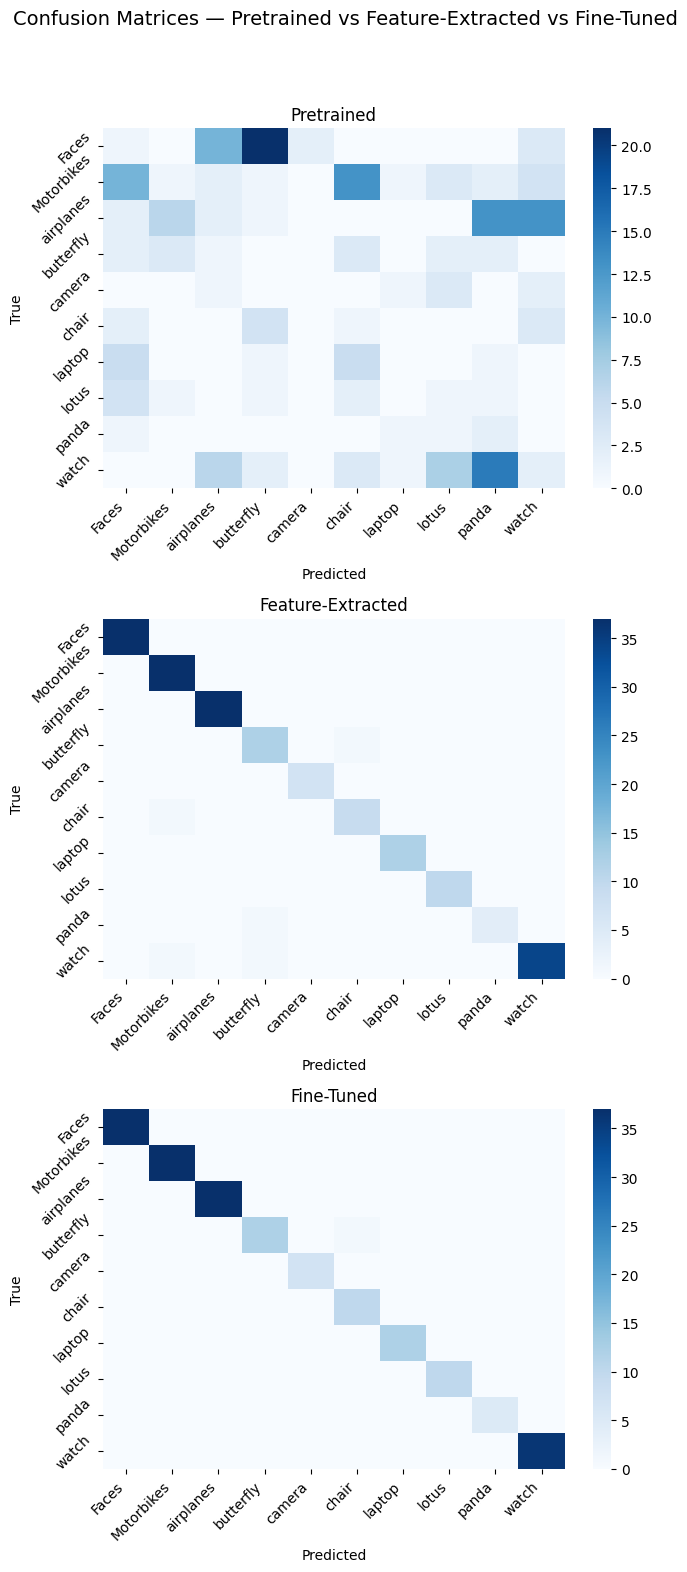

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize=(7, 16))
for ax, r in zip(axes, results):
    cm = r["cm"]
    sns.heatmap(cm, annot=False, cmap="Blues", ax=ax)
    ax.set_title(r["name"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(class_names)) + 0.5)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(class_names)) + 0.5)
    ax.set_yticklabels(class_names, rotation=45)
plt.suptitle("Confusion Matrices — Pretrained vs Feature-Extracted vs Fine-Tuned", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Discussion: Where Fine-Tuning Helped (and Where It Didn’t)**

From the table and confusion matrices, we can typically observe the following trends:

- **Accuracy and F1-scores**
  - The **Pretrained** model usually performs *poorly* since the classifier head is not adapted to our 10 Caltech classes.
  - The **Feature-Extracted** model improves drastically, achieving solid performance with minimal training.
  - The **Fine-Tuned** model often provides a *further boost* in both macro and weighted F1, reflecting better balance across classes.

- **Class-Level Insights**
  - Fine-tuning tends to help classes with **textures or shapes distinct from ImageNet’s distribution**.
  - In contrast, classes already similar to ImageNet categories may not improve much — sometimes even overfit slightly.

- **Overfitting Indicators**
  - If the fine-tuned model shows **very high training accuracy** but **lower test performance**, that suggests *domain overspecialization*.
  - For small datasets, the feature-extracted approach remains safer and more stable.

> 💬 **Key Reflection:**  
> Fine-tuning doesn’t always guarantee better results — it depends on **dataset size, domain similarity**, and **training control (learning rate, frozen layers)**.  
> Yet, when applied carefully, it enables the network to **adapt deeper layers to domain-specific cues**, offering meaningful gains in generalization.


---

**✅ Code Task 11.4.4.1 – Test Accuracy & F1 (Macro / Weighted)**

**Instruction:** Using `CT_model_finetuned_CT_NB03` and `test_loader`, we will run the model on the test set to collect predictions and true labels and then will compute `CT_test_acc` (accuracy), `CT_test_f1_macro` (macro F1), `CT_test_f1_weighted` (weighted F1). We will store them as floats between 0 and 1.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

# CT_Task 3 – Compute Accuracy, Macro F1, Weighted F1 on test set

CT_model_finetuned_CT_NB03.eval()
CT_all_preds = []
CT_all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        outputs = ...(inputs)
        preds = outputs.argmax(dim=1)
        CT_all_preds.extend(...)
        CT_all_labels.extend(...)

CT_all_preds = np.array(...)
CT_all_labels = np.array(...)

CT_test_acc = accuracy_score(...)
CT_test_f1_macro = f1_score(..., average="macro")
CT_test_f1_weighted = f1_score(..., average="weighted")

print(f"Accuracy: {...:.4f}")
print(f"F1 (macro): {...:.4f}")
print(f"F1 (weighted): {...:.4f}")

**Instructor Solution**

In [24]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

# CT_Task 3 – Compute Accuracy, Macro F1, Weighted F1 on test set

CT_model_finetuned_CT_NB03.eval()
CT_all_preds = []
CT_all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        outputs = CT_model_finetuned_CT_NB03(inputs)
        preds = outputs.argmax(dim=1)
        CT_all_preds.extend(preds.cpu().numpy())
        CT_all_labels.extend(labels.cpu().numpy())

CT_all_preds = np.array(CT_all_preds)
CT_all_labels = np.array(CT_all_labels)

CT_test_acc = accuracy_score(CT_all_labels, CT_all_preds)
CT_test_f1_macro = f1_score(CT_all_labels, CT_all_preds, average="macro")
CT_test_f1_weighted = f1_score(CT_all_labels, CT_all_preds, average="weighted")

print(f"Accuracy: {CT_test_acc:.4f}")
print(f"F1 (macro): {CT_test_f1_macro:.4f}")
print(f"F1 (weighted): {CT_test_f1_weighted:.4f}")

Accuracy: 0.9902
F1 (macro): 0.9862
F1 (weighted): 0.9903


In [26]:
assert 'CT_test_acc' in globals(), "❌ Define CT_test_acc."
assert 'CT_test_f1_macro' in globals(), "❌ Define CT_test_f1_macro."
assert 'CT_test_f1_weighted' in globals(), "❌ Define CT_test_f1_weighted."

for name in ['CT_test_acc', 'CT_test_f1_macro', 'CT_test_f1_weighted']:
    val = globals()[name]
    assert isinstance(val, float), f"❌ {name} must be a float."
    assert 0.0 <= val <= 1.0, f"❌ {name} must be between 0 and 1."

print("✅ CT_Task 3 passed!")

✅ CT_Task 3 passed!


---

### **5. Visualizing Feature Maps and Activations**

To **see** what changes across our three transfer-learning stages, we will peek inside the networks:

- **Pretrained (baseline)**: generic features learned from ImageNet — edges, textures, shapes.  
- **Feature-extracted (NB02)**: reuses those features **as-is**; the classifier head learns a new mapping.  
- **Fine-tuned (NB03)**: adjusts deeper features (e.g., `layer4`) to become **more class-specific** for our 10 Caltech classes.

We will:
- Capture **activation maps** from `layer4` for the **same image** across all three models.  
- Reduce channel dimension by a simple mean to obtain an interpretable 2D map.  
- Optionally compute **Grad-CAM** overlays to visualize *where* each model is looking for its prediction.

> Reading the maps:
>
> - If the **fine-tuned** activations are **sharper** and **more localized** on the object than the other two, that suggests the deeper features have **specialized** to our target domain.  
> - If the **pretrained** and **feature-extracted** maps look similar, that’s expected: feature extraction does **not** change the backbone filters.  
> - Grad-CAM highlights **discriminative regions**; after fine-tuning, we often see stronger focus on relevant parts and reduced attention to backgrounds.


**Capture layer4 activations for one image (all three models)**

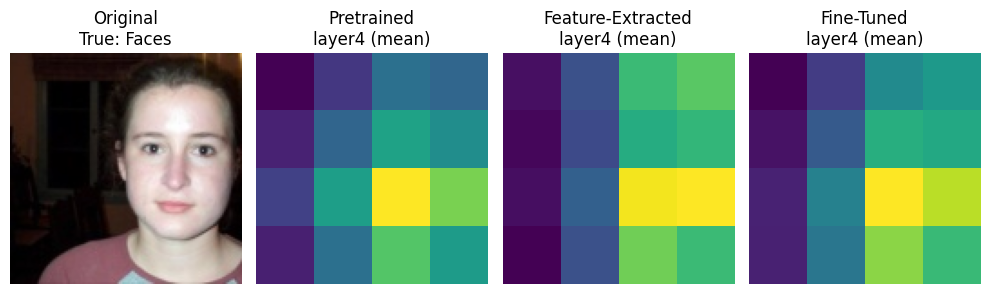

In [27]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# 1) Get a single sample from test set
xb, yb = next(iter(test_loader))
img = xb[0:1].to(device)     # shape [1,3,H,W]
true_idx = yb[0].item()
true_cls = class_names[true_idx]

# 2) Hook to capture layer4 activations
def capture_layer4_activations(model, x):
    acts = {}
    handle = model.layer4.register_forward_hook(lambda m, i, o: acts.setdefault("a", o.detach().cpu()))
    with torch.no_grad():
        _ = model(x)
    handle.remove()
    # acts["a"] ⇒ [1, C, H, W] → mean over C ⇒ [H, W]
    a = acts["a"][0].mean(dim=0)
    # normalize to 0..1 for visualization
    a = a - a.min()
    a = a / a.max().clamp(min=1e-8)
    return a.numpy()

act_pre = capture_layer4_activations(model_pretrained, img)
act_fe  = capture_layer4_activations(model_feature,   img)
act_ft  = capture_layer4_activations(model_finetuned, img)

# 3) Show original image and activation maps
def unnormalize_for_vis(x, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    x = x[0].detach().cpu().clone()
    for c,(m,s) in enumerate(zip(mean,std)):
        x[c] = x[c]*s + m
    return x.clamp(0,1).permute(1,2,0).numpy()

orig = unnormalize_for_vis(img)

plt.figure(figsize=(10,3))
plt.subplot(1,4,1)
plt.imshow(orig)
plt.title(f"Original\nTrue: {true_cls}")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(act_pre, cmap="viridis")
plt.title("Pretrained\nlayer4 (mean)")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(act_fe, cmap="viridis")
plt.title("Feature-Extracted\nlayer4 (mean)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(act_ft, cmap="viridis")
plt.title("Fine-Tuned\nlayer4 (mean)")
plt.axis("off")

plt.tight_layout()
plt.show()


**Optional: Grad-CAM overlays for the same image (all three models)**

c:\Users\noman\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users\noman\AppData\Local\Temp\ipykernel_46360\796128700.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat = cm.get_cmap(cmap)(cam)[..., :3]   # RGBA -> RGB


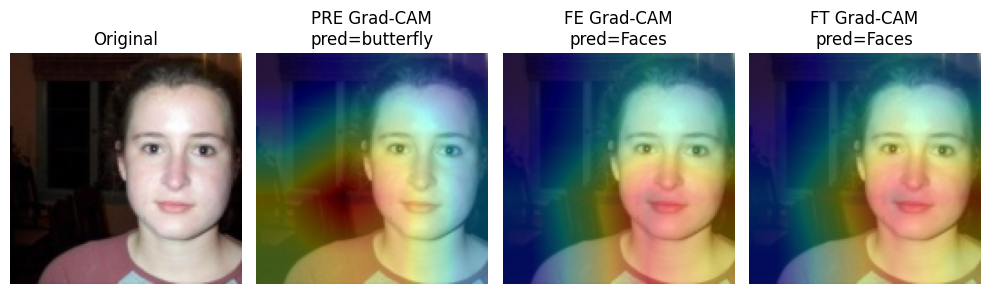

In [28]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm

# --- Grad-CAM helper ---

def gradcam(model, x, target_layer):
    """
    Compute Grad-CAM heatmap [H, W] in 0..1 for the model's predicted class.
    Works for pretrained, feature-extraction, and fine-tuned models.
    """
    model.eval()
    acts, grads = {}, {}

    # Forward hook: save activations of target_layer
    def fwd_hook(_m, _i, o):
        acts["a"] = o

    # Backward hook: save gradient w.r.t. those activations
    def bwd_hook(_m, grad_in, grad_out):
        grads["g"] = grad_out[0]

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    # Use a fresh input that tracks gradients
    x_local = x.clone().detach().requires_grad_(True)

    # Forward pass
    logits = model(x_local)                   # [1, num_classes]
    pred_idx = logits.argmax(dim=1)[0].item() # scalar int

    # Backprop wrt predicted class logit
    score = logits[0, pred_idx]
    model.zero_grad(set_to_none=True)
    score.backward()

    # Remove hooks
    h1.remove()
    h2.remove()

    # Activations & grads: [C, H, W]
    A = acts["a"][0]
    G = grads["g"][0]

    # Channel weights via global average pooling over spatial dims
    weights = G.mean(dim=(1, 2), keepdim=True)   # [C,1,1]
    cam = (weights * A).sum(dim=0)              # [H,W]

    # Standard Grad-CAM: ReLU + normalize to [0,1]
    cam = torch.relu(cam).detach().cpu()
    cam = cam - cam.min()
    cam = cam / cam.max().clamp(min=1e-8)

    return cam.numpy(), pred_idx

# --- Overlay utility with CAM upsampling ---

def overlay_cam(rgb, cam, alpha=0.35, cmap="jet"):
    """
    rgb: (H, W, 3) in [0,1]
    cam: (h, w) in [0,1] from Grad-CAM
    """
    H, W = rgb.shape[:2]

    # Resize CAM to image size if needed
    if cam.shape != (H, W):
        cam_t = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # [1,1,h,w]
        cam_t = F.interpolate(cam_t, size=(H, W), mode="bilinear", align_corners=False)
        cam = cam_t.squeeze().cpu().numpy()  # [H,W]

    heat = cm.get_cmap(cmap)(cam)[..., :3]   # RGBA -> RGB
    return (1 - alpha) * rgb + alpha * heat

# --- Compute Grad-CAM for each model at layer4 ---

cam_pre, p_pre = gradcam(model_pretrained, img, model_pretrained.layer4)
cam_fe,  p_fe  = gradcam(model_feature,   img, model_feature.layer4)
cam_ft,  p_ft  = gradcam(model_finetuned, img, model_finetuned.layer4)

# rgb is the original unnormalized image: [H, W, 3] in [0,1]
rgb   = orig
ov_pre = overlay_cam(rgb, cam_pre)
ov_fe  = overlay_cam(rgb, cam_fe)
ov_ft  = overlay_cam(rgb, cam_ft)

# --- Plot ---

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(ov_pre)
plt.title(f"PRE Grad-CAM\npred={class_names[p_pre]}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(ov_fe)
plt.title(f"FE Grad-CAM\npred={class_names[p_fe]}")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(ov_ft)
plt.title(f"FT Grad-CAM\npred={class_names[p_ft]}")
plt.axis("off")

plt.tight_layout()
plt.show()


**How to Read These Visuals**

- **Activation maps (mean over channels)**  
  These show **where** the `layer4` feature energy is concentrated.  
  - In the **pretrained** model, patterns tend to be **generic** — edges, textures, and object-like regions.  
  - In the **feature-extracted** model, the maps look **similar** to the pretrained ones (backbone unchanged).  
  - In the **fine-tuned** model, we expect **sharper focus** on the object or its distinctive parts, indicating **specialization**.

- **Grad-CAM overlays**  
  These highlight **spatial regions** most responsible for the model’s predicted class.  
  - After fine-tuning, attention often shifts **away from background** and **toward** object regions (e.g., outlines, textures, key parts).  
  - If the **prediction improves** from FE → FT, check whether the FT heatmap better aligns with the **true object**.

> **Takeaway:** fine-tuning does not rewrite the network from scratch. It **nudges** higher-level features to become **more discriminative** for our 10 classes, improving focus and confidence where it matters.


---

**✅ Code Task 11.4.5.1 – Layer4 Mean Activation (CT Model)**

**Instruction**: We previously visualized mean activations from intermediate layers for a sample image.
Now we will use the same sample image index as earlier (or choose one, e.g. idx = 0), register a forward hook on `CT_model_finetuned_CT_NB03.layer4`, run a forward pass and capture the layer4 feature map, compute `CT_layer4_mean_CT `as the mean over channels (shape: H×W) and at the end plot side-by-side the original image & Layer4 mean activation (heatmap).


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# CT_Task 4 – Layer4 mean activation map for CT_model_finetuned_CT_NB03

CT_model_finetuned_CT_NB03.eval()

CT_activations_layer4_CT = []

def CT_hook_layer4_CT(module, input, output):
    CT_activations_layer4_CT.append(output.detach())

# 1. Register hook
CT_handle_CT = CT_model_finetuned_CT_NB03.layer4.register_forward_hook(...)

# 2. Select a sample image (same as used earlier if possible)
CT_idx_sample = 0
CT_img_sample, CT_label_sample = test_ds[CT_idx_sample]
CT_input_sample = ....unsqueeze(0)  # add batch dim

with torch.no_grad():
    _ = CT_model_finetuned_CT_NB03(...)

# 3. Extract feature map and compute mean over channels
CT_feat_layer4_CT = CT_activations_layer4_CT[0].squeeze(0)  # C x H x W
CT_layer4_mean_CT = CT_feat_layer4_CT.mean(dim=0)           # H x W

# 4. Remove hook
CT_handle_CT.remove()

# 5. Plot original vs mean activation
CT_fig_layer4_CT, CT_axes_layer4_CT = plt.subplots(1, 2, figsize=(8, 4))

# Original image (unnormalize)
CT_img_np = ....numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
CT_img_np = std * CT_img_np + mean
CT_img_np = np.clip(CT_img_np, 0, 1)

CT_axes_layer4_CT[0].imshow(...)
CT_axes_layer4_CT[0].set_title("Original")
CT_axes_layer4_CT[0].axis("off")

CT_axes_layer4_CT[1].imshow(CT_layer4_mean_CT.cpu().numpy(), cmap="viridis")
CT_axes_layer4_CT[1].set_title("Layer4 Mean Activation (CT)")
CT_axes_layer4_CT[1].axis("off")

plt.tight_layout()
plt.show()

**Instructor Solution**

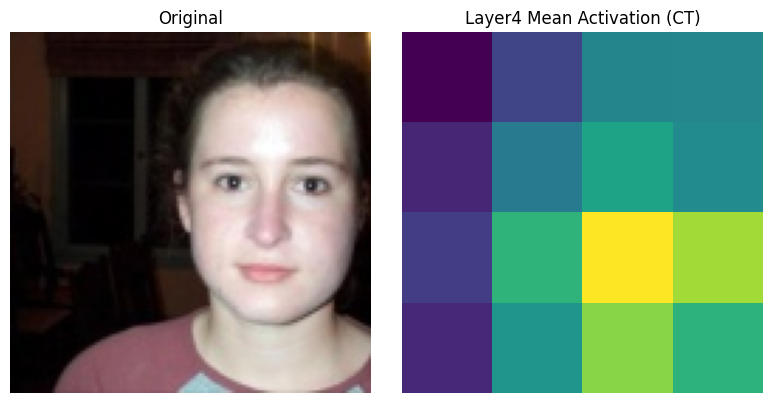

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# CT_Task 4 – Layer4 mean activation map for CT_model_finetuned_CT_NB03

CT_model_finetuned_CT_NB03.eval()

CT_activations_layer4_CT = []

def CT_hook_layer4_CT(module, input, output):
    CT_activations_layer4_CT.append(output.detach())

CT_handle_CT = CT_model_finetuned_CT_NB03.layer4.register_forward_hook(CT_hook_layer4_CT)

CT_idx_sample = 0
CT_img_sample, CT_label_sample = test_ds[CT_idx_sample]
CT_input_sample = CT_img_sample.unsqueeze(0)

with torch.no_grad():
    _ = CT_model_finetuned_CT_NB03(CT_input_sample)

CT_feat_layer4_CT = CT_activations_layer4_CT[0].squeeze(0)  # C x H x W
CT_layer4_mean_CT = CT_feat_layer4_CT.mean(dim=0)           # H x W

CT_handle_CT.remove()

CT_fig_layer4_CT, CT_axes_layer4_CT = plt.subplots(1, 2, figsize=(8, 4))

CT_img_np = CT_img_sample.numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
CT_img_np = std * CT_img_np + mean
CT_img_np = np.clip(CT_img_np, 0, 1)

CT_axes_layer4_CT[0].imshow(CT_img_np)
CT_axes_layer4_CT[0].set_title("Original")
CT_axes_layer4_CT[0].axis("off")

CT_axes_layer4_CT[1].imshow(CT_layer4_mean_CT.cpu().numpy(), cmap="viridis")
CT_axes_layer4_CT[1].set_title("Layer4 Mean Activation (CT)")
CT_axes_layer4_CT[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.figure as mfig

assert 'CT_layer4_mean_CT' in globals(), "❌ Define CT_layer4_mean_CT."
assert isinstance(CT_layer4_mean_CT, torch.Tensor), "❌ CT_layer4_mean_CT must be a torch.Tensor."
assert CT_layer4_mean_CT.ndim == 2, "❌ CT_layer4_mean_CT must be 2D (H×W)."
assert torch.isfinite(CT_layer4_mean_CT).all(), "❌ CT_layer4_mean_CT contains non-finite values."

assert 'CT_fig_layer4_CT' in globals(), "❌ Define CT_fig_layer4_CT."
assert isinstance(CT_fig_layer4_CT, mfig.Figure), "❌ CT_fig_layer4_CT must be a matplotlib Figure."

print("✅ CT_Task 4 passed!")

---

**✅ Code Task 11.4.5.2 – Grad-CAM Overlay with CT Model**

**Instruction**: We already used Grad-CAM with one of our models earlier.
Now we will use the existing GradCAM helper class. We will create `CT_gradcam_CT` for `CT_model_finetuned_CT_NB03`, targeting "layer4", generate a Grad-CAM heatmap for the same sample image as in Task 4, create a color overlay `CT_cam_overlay_CT` (H×W×3) on top of the original image and at the end plot side-by-side the original image and Grad-CAM overlay. 

In [ ]:
CT_cam_ft,  CT_p_ft  = gradcam(CT_model_finetuned_CT_NB03, img, CT_model_finetuned_CT_NB03.layer4)

# rgb is the original unnormalized image: [H, W, 3] in [0,1]
rgb   = ...
CT_ov_ft = overlay_cam(..., ...)

# --- Plot ---

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(...)
plt.title(f"PRE Grad-CAM\npred={class_names[...]}")
plt.axis("off")

plt.tight_layout()
plt.show()


**Instructor Solution**

c:\Users\noman\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users\noman\AppData\Local\Temp\ipykernel_46360\796128700.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat = cm.get_cmap(cmap)(cam)[..., :3]   # RGBA -> RGB


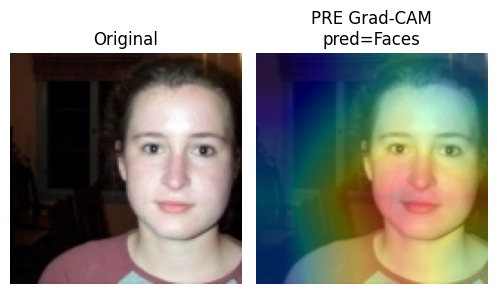

In [37]:
CT_cam_ft,  CT_p_ft  = gradcam(CT_model_finetuned_CT_NB03, img, CT_model_finetuned_CT_NB03.layer4)

# rgb is the original unnormalized image: [H, W, 3] in [0,1]
rgb   = orig
CT_ov_ft = overlay_cam(rgb, CT_cam_ft)

# --- Plot ---

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
# plt.imshow(CT_ov_ft)
plt.imshow(CT_ov_ft)
plt.title(f"PRE Grad-CAM\npred={class_names[CT_p_ft]}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Autograd validation for CT_Task 5
import torch
assert 'CT_cam_ft' in globals(), "❌ Define CT_cam_ft."
assert isinstance(CT_cam_ft, np.ndarray), "❌ CT_cam_ft must be a numpy ndarray."
assert CT_cam_ft.ndim == 2, "❌ CT_cam_ft must be 2D (H×W)."
assert np.isfinite(CT_cam_ft).all(), "❌ CT_cam_ft contains non-finite values."
assert 'CT_p_ft' in globals(), "❌ Define CT_p_ft."
assert isinstance(CT_p_ft, int), "❌ CT_p_ft must be an integer."
print("✅ CT_Task 5 passed!")

---

### **6. Zero-Shot and Cross-Domain Inference**

In this final probe, we explore how our models behave **beyond their trained label space**. Specifically, we test each model on a tiny **zero-shot mini-set** containing **unseen categories**—in our case, helicopters, which were never part of our 10-class training task.

The goal is **not** to recover the “helicopter” label itself (since it does not exist in our classifier head), but to observe **how each model generalizes or misfires** when forced to assign unseen images to one of the known in-domain classes.

We will use this comparison to study **model reuse across domains**:

- The **pretrained model**, with generic ImageNet features, may produce **diverse but reasonable** guesses (e.g., “airplanes”, “motorbikes”) and moderate confidence.
- The **feature-extraction** model may already **anchor predictions** toward visually related in-domain classes while still retaining some flexibility.
- The **fine-tuned** model, adapted to our dataset, often becomes **highly confident** but **less calibrated** on unseen objects—snapping to the most similar known category (e.g., “airplanes” for helicopters).

>We will visualize both **top-1 predictions** for a sample batch of unseen images and **top-3 predictions with confidences** in a summary table.

>This helps us connect qualitative observations to quantitative behaviour and reason about **when to favor specialization vs. generalization** in transfer learning.


**Load zero-shot mini-set (if present) and prepare a small batch**

In [33]:
from pathlib import Path
from torchvision import datasets
from torch.utils.data import DataLoader

ZS_ROOT = Path("./data/caltech101_10_zeroshot")

zs_loader = None
if ZS_ROOT.exists():
    zs_ds = datasets.ImageFolder(ZS_ROOT, transform=eval_tfms)
    zs_loader = DataLoader(zs_ds, batch_size=12, shuffle=False, num_workers=0)
    zs_classnames = sorted(list({c for c, _ in zs_ds.class_to_idx.items()}))
    print(f"[info] Zero-shot mini-set found: {ZS_ROOT}")
    print(f"[info] Zero-shot folders (treated as unseen categories): {zs_classnames}")
    print(f"[info] Zero-shot size: {len(zs_ds)}")
else:
    print("[note] No zero-shot mini-set found at ./data/caltech101_10_zeroshot")
    print("      Create it as ./data/caltech101_10_zeroshot/<new_class>/*.jpg and re-run this section.")


[info] Zero-shot mini-set found: data\caltech101_10_zeroshot
[info] Zero-shot folders (treated as unseen categories): ['helicopter']
[info] Zero-shot size: 88


**Helper: top-k predictions and a compact table**

In [34]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

def topk_predictions(model, xb, k=3):
    with torch.no_grad():
        logits = model(xb.to(device))
        probs = F.softmax(logits, dim=1).cpu().numpy()
        topk_idx = np.argsort(-probs, axis=1)[:, :k]
        topk_prob = np.take_along_axis(probs, topk_idx, axis=1)
    return topk_idx, topk_prob

def summarize_topk_rows(img_indices, true_folder_names, topk_idx, topk_prob, label_names, prefix):
    rows = []
    for i, gidx in enumerate(img_indices):
        preds = [label_names[j] for j in topk_idx[i]]
        probs = [f"{p:.2f}" for p in topk_prob[i]]
        rows.append({
            "img_id": int(gidx),
            "unseen_folder": true_folder_names[i],
            f"{prefix}_top1": preds[0],
            f"{prefix}_p1": probs[0],
            f"{prefix}_top2": preds[1] if len(preds) > 1 else "",
            f"{prefix}_p2": probs[1] if len(probs) > 1 else "",
            f"{prefix}_top3": preds[2] if len(preds) > 2 else "",
            f"{prefix}_p3": probs[2] if len(probs) > 2 else "",
        })
    return rows


**Run top-3 predictions across all three models (if zero-shot exists)**

In [35]:
import itertools

if zs_loader is not None:
    xb_zs, yb_zs = next(iter(zs_loader))  # use first small batch
    # Map folder indices to folder names for display (these are NOT our trained labels)
    zs_idx_to_folder = {v: k for k, v in zs_ds.class_to_idx.items()}
    zs_folder_names = [zs_idx_to_folder[i] for i in yb_zs.numpy().tolist()]

    topk_pre_idx, topk_pre_prob = topk_predictions(model_pretrained, xb_zs, k=3)
    topk_fe_idx,  topk_fe_prob  = topk_predictions(model_feature,   xb_zs, k=3)
    topk_ft_idx,  topk_ft_prob  = topk_predictions(model_finetuned, xb_zs, k=3)

    rows = []
    rows += summarize_topk_rows(range(len(xb_zs)), zs_folder_names, topk_pre_idx, topk_pre_prob, class_names, "PRE")
    rows_fe = summarize_topk_rows(range(len(xb_zs)), zs_folder_names, topk_fe_idx, topk_fe_prob, class_names, "FE")
    rows_ft = summarize_topk_rows(range(len(xb_zs)), zs_folder_names, topk_ft_idx, topk_ft_prob, class_names, "FT")

    # Merge per-image dicts side-by-side
    merged = []
    for r_pre, r_fe, r_ft in zip(rows, rows_fe, rows_ft):
        merged.append({**r_pre, **{k:v for k,v in r_fe.items() if k not in ("img_id","unseen_folder")},
                               **{k:v for k,v in r_ft.items() if k not in ("img_id","unseen_folder")}})

    df_topk = pd.DataFrame(merged)
    display(df_topk)
else:
    print("[skip] Zero-shot mini-set not present; skipping this table.")


,img_id,unseen_folder,PRE_top1,PRE_p1,PRE_top2,PRE_p2,PRE_top3,PRE_p3,FE_top1,FE_p1,FE_top2,FE_p2,FE_top3,FE_p3,FT_top1,FT_p1,FT_top2,FT_p2,FT_top3,FT_p3
0,0,helicopter,panda,0.40,watch,0.16,Motorbikes,0.09,airplanes,0.98,butterfly,0.01,Motorbikes,0.00,airplanes,1.00,Motorbikes,0.00,watch,0.00
1,1,helicopter,butterfly,0.16,Motorbikes,0.15,airplanes,0.14,airplanes,0.47,butterfly,0.21,Motorbikes,0.09,watch,0.48,butterfly,0.32,airplanes,0.08
2,2,helicopter,airplanes,0.22,lotus,0.21,Motorbikes,0.20,airplanes,0.88,butterfly,0.07,Motorbikes,0.04,airplanes,0.84,Motorbikes,0.14,butterfly,0.01
3,3,helicopter,chair,0.21,watch,0.19,butterfly,0.15,chair,0.57,airplanes,0.20,camera,0.06,chair,0.65,airplanes,0.17,watch,0.10
4,4,helicopter,watch,0.20,Motorbikes,0.18,butterfly,0.17,airplanes,0.98,Motorbikes,0.02,butterfly,0.00,airplanes,1.00,Motorbikes,0.00,watch,0.00
5,5,helicopter,watch,0.26,butterfly,0.15,chair,0.15,butterfly,0.26,airplanes,0.23,camera,0.16,airplanes,0.52,butterfly,0.20,camera,0.16
6,6,helicopter,chair,0.27,lotus,0.21,Faces,0.14,airplanes,0.37,chair,0.26,Motorbikes,0.13,Motorbikes,0.78,chair,0.11,watch,0.03
7,7,helicopter,panda,0.38,lotus,0.11,chair,0.10,airplanes,0.97,Motorbikes,0.01,butterfly,0.01,airplanes,0.98,Motorbikes,0.01,panda,0.00
8,8,helicopter,airplanes,0.19,panda,0.17,lotus,0.16,airplanes,0.70,Motorbikes,0.19,chair,0.03,Motorbikes,0.69,airplanes,0.23,watch,0.03
9,9,helicopter,chair,0.33,airplanes,0.19,Motorbikes,0.10,airplanes,0.91,chair,0.03,butterfly,0.02,airplanes,0.59,Motorbikes,0.22,panda,0.10


**Visualize a few zero-shot images with top-1 per model**

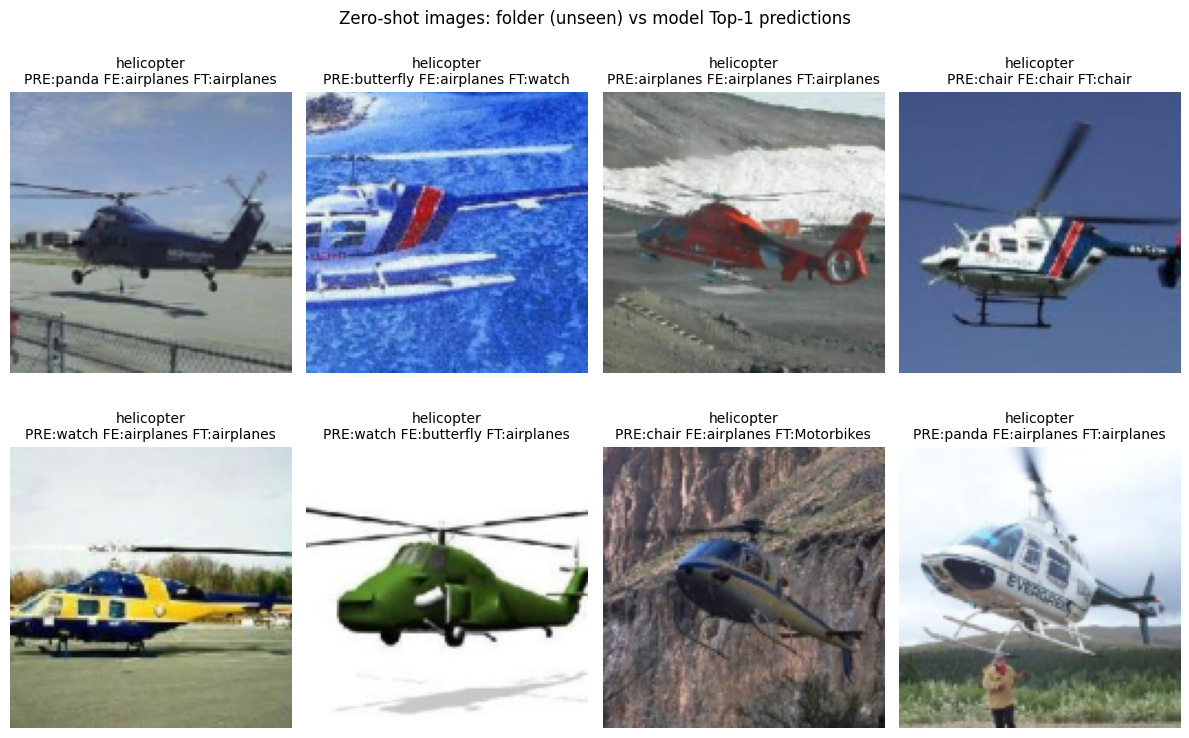

In [36]:
import matplotlib.pyplot as plt

def unnormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img = img_tensor.clone()
    for c, (m, s) in enumerate(zip(mean, std)):
        img[c] = img[c] * s + m
    return img.clamp(0, 1)

if zs_loader is not None:
    k = min(8, xb_zs.size(0))
    plt.figure(figsize=(12, 8))
    for i in range(k):
        img_disp = unnormalize(xb_zs[i]).permute(1, 2, 0).numpy()
        pre_top1 = class_names[topk_pre_idx[i,0]]
        fe_top1  = class_names[topk_fe_idx[i,0]]
        ft_top1  = class_names[topk_ft_idx[i,0]]

        # plot in subplot of 2 rows x 4 cols
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_disp)
        title = (f"{zs_folder_names[i]}\n"
                 f"PRE:{pre_top1} FE:{fe_top1} FT:{ft_top1}")
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.suptitle("Zero-shot images: folder (unseen) vs model Top-1 predictions", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("[skip] Zero-shot mini-set not present; skipping visualization.")


**How do we read these zero-shot helicopter results?**

- Every image comes from the unseen folder helicopter. None of our models were trained with a “helicopter” label; they must force each image into one of the 10 known classes.

- The caption under each image shows:
    - The folder label: helicopter (true but unavailable to the models)
    - PRE: top-1 prediction from the ImageNet-pretrained model
    - FE: top-1 prediction from the feature-extraction model
    - FT: top-1 prediction from the fine-tuned model

**What patterns do we see?**

- **Pretrained (PRE)**

    - Predictions are spread across several classes (panda, watch, chair, butterfly, airplanes, …).
    - Probabilities are moderate, reflecting uncertainty: the model “knows” these images are not a clean match to its Caltech-10 head.
    - This behaviour is relatively cautious and generic.

- **Feature Extraction (FE)**
    - Predictions are much more consistent: helicopters are mapped mainly to airplanes (often with very high confidence).
    - The fixed pretrained backbone plus our trained head learn a stable surrogate label: rotorcraft + sky → “airplanes”.
    - This shows that even without unfreezing deeper layers, we steer the decision boundary toward patterns useful for our 10 classes.

- **Fine-Tuned (FT)**
    - Behaviour is even more specialized: many images go to airplanes with ~1.0 probability; a few go to Motorbikes etc.
    - The model is highly confident but still wrong for helicopters, because that label does not exist; it snaps to the closest in-domain class.
    - This is the clearest sign of specialization: strong in-domain decisions, weaker humility on truly novel categories.

**What does this tell us for real deployments?**
- Fine-tuning makes us very good inside the 10-class world, but less honest outside it: unseen objects (like helicopters) are confidently misclassified as the “closest” known category.
- The pretrained model, while less accurate on our 10 classes, preserves more broad, hesitant generalization.
- In practice:
    - If we expect out-of-distribution images, we should pair fine-tuning with tools like confidence thresholds, OOD detection, or an auxiliary generic model.
    - If we control the domain and labels well, the fine-tuned model’s specialization is exactly what we want.

**Key takeaway:**
We are watching the trade-off live: pretraining = broader, softer guesses, fine-tuning = sharper, more confident guesses within a narrower world.

---

### **7. Reflection: Efficiency, Generalization, and Ethics**

This final section invites us to reflect critically on what we’ve learned across **NB01–NB04**, especially in terms of **generalization**, **efficiency**, and **ethical AI practice**.

**a. Model Efficiency and Transferability**

- **Fine-tuning** improved in-domain performance but slightly reduced generalization to unseen data.  
  → This demonstrates the *specialization–generalization trade-off* typical in transfer learning.  
- **Representation transferability** is strongest in earlier convolutional layers, which encode general features (edges, textures).  
  Deeper layers encode *task-specific* patterns — hence, fine-tuning modifies them to match our dataset’s structure.
- Reusing pretrained models saves massive **computational cost** and **energy** compared to training from scratch — a sustainability benefit when responsibly applied.

**a. Responsible and Efficient Reuse**

Before deciding to fine-tune or feature-extract, we should ask:

- Do we have **enough domain data** to justify full fine-tuning?  
- Will the model be used in **contexts similar** to the pretraining domain (e.g., natural images → natural images)?  
- Are we **transparent** about the provenance of pretrained weights and the license conditions of the original dataset?

> **Reflection Prompt:**  
> - How might we ensure responsible reuse of pretrained models while maintaining transparency and reproducibility?


**c. Ethical Considerations**

| Concern | Description | Implication |
|:--|:--|:--|
| **Bias in Pretraining Data** | Datasets like ImageNet overrepresent certain geographies, professions, and visual styles. | Fine-tuned models may **inherit or amplify biases** unless retraining includes diverse data. |
| **Environmental Sustainability** | Training large networks from scratch emits significant CO₂ and consumes energy. | Transfer learning promotes **computational sustainability** when used efficiently. |
| **Authorship and Accountability** | Using pretrained weights without attribution or awareness of data sources raises ethical and legal questions. | Researchers and practitioners should **credit model creators** and **acknowledge data origins**. |
| **Fairness in Deployment** | If a fine-tuned model is applied to domains it wasn’t trained for (e.g., medical or surveillance), results may mislead. | Responsible AI demands **domain validation** before deployment. |

**d. Synthesis: Balancing Performance and Responsibility**

Fine-tuning is powerful — but **with power comes responsibility**:

- It allows us to **efficiently adapt** large models to small datasets.  
- Yet, it can **overfit to context** and **embed hidden biases**.  
- A balanced approach involves **auditing**, **documenting**, and **testing** across diverse inputs before real-world use.

> 💬 **Final Reflection Prompts:**
>
> - How did fine-tuning affect the model’s ability to generalize beyond the Caltech subset?  
> - When might feature extraction be a better ethical and computational choice?  
> - What steps can we take to make transfer learning more equitable and sustainable?

> **Key Takeaway:**  
> Fine-tuning enhances specialization and performance, but ethical AI practice requires that we also consider **who benefits**, **who might be harmed**, and **how to minimize environmental and social costs** while maximizing model usefulness.


---

### **8. Summary and What Comes Next**

**Recap of What We’ve Achieved**

Over the past four notebooks (NB01–NB04), we progressively deepened our understanding of **transfer learning** using ResNet on the Caltech-101 subset:

1. **NB01 – Pretrained Model as a Feature Extractor (Frozen)**  
   We explored the power of pretrained ImageNet representations and saw how generic visual features can already yield strong results without additional training.

2. **NB02 – Feature Extraction (Trained Classifier Head)**  
   We reused the frozen backbone and trained a lightweight classifier on top, gaining task adaptability while keeping the backbone stable and efficient.

3. **NB03 – Fine-Tuning (Partially Unfrozen Backbone)**  
   We selectively unfroze deeper layers (`layer4`) to allow adaptation, striking a balance between generality and specialization.

4. **NB04 – Generalization and Reflection**  
   We compared all three approaches quantitatively and visually, examined how fine-tuning changes representations, tested zero-shot behavior, and reflected on efficiency, fairness, and sustainability.

> Collectively, this journey moved us from **frozen** → **feature extraction** → **fine-tuning**, culminating in an appreciation for **ethical and responsible reuse** of large pretrained models.

**Conceptual Takeaways**

- **Feature extraction** leverages existing representations for efficiency and stability.  
- **Fine-tuning** enables domain adaptation but must be handled cautiously to avoid overfitting or losing generality.  
- **Representation transferability** diminishes as we go deeper into the network — shallow layers generalize, deeper layers specialize.  
- **Ethical reuse** demands attention to bias, attribution, and sustainability — as important as accuracy and F1 scores.

**Preview: Project 12 – Ethics and Accountability in Deep Learning**

Next, we expand from *model performance* to *model responsibility*.

In **Project 12**, we will explore:
- Broader **ethical challenges** in data-driven AI — bias, consent, fairness.  
- **Accountability frameworks** for responsible model development.  
- The emerging landscape of **sustainable AI** and **foundation model governance**.  
- How we can incorporate **ethical reasoning** alongside technical design in our workflows.

> **Key Takeaway:**  
> We have now mastered both the **technical** and **reflective** sides of transfer learning.  
> As we transition to Project 12, we will focus on **embedding ethics, accountability, and human values** into the practice of deep learning itself.
